# **DELHIVERY BUSINESS CASE STUDY**

---
---
---

## **PROBLEM STATEMENT**

Delhivery manages a nationwide logistics network where shipment movement involves multiple routes and delivery segments. While routing engines such as OSRM provide estimated travel times and distances, the **actual delivery performance frequently varies** due to real-world operational conditions, including traffic patterns, hub processing delays, and transportation mode differences.

To enhance planning accuracy and operational efficiency, it is essential to **systematically analyze and refine the raw trip and segment-level data** generated from logistics pipelines.

This project focuses on:

* **Cleaning and transforming raw operational data** into analysis-ready form
* **Engineering features** that capture routing efficiency, delay behavior, and route performance
* **Identifying consistently underperforming routes and delivery segments**
* Enabling the **data science team to build robust delivery time forecasting models**

By deriving meaningful insights and predictive features from logistics data, Delhivery can **improve route planning, reduce delays, optimize resource utilization, and strengthen its competitive advantage** in the supply chain and last-mile delivery market.

---


## **MODULES' IMPORT**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

---

## **DATA IMPORT**

In [ ]:
!wget https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181

--2025-11-20 17:13:21--  https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181
Resolving d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)... 3.165.84.188, 3.165.84.114, 3.165.84.173, ...
Connecting to d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)|3.165.84.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55617130 (53M) [text/plain]
Saving to: ‘delhivery_data.csv?1642751181’

delhivery_data.csv? 100%[===================>]  53.04M   270MB/s    in 0.2s    

2025-11-20 17:13:21 (270 MB/s) - ‘delhivery_data.csv?1642751181’ saved [55617130/55617130]



In [ ]:
df = pd.read_csv('delhivery_data.csv?1642751181')
df.head(2)

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111


## **BASIC METRICS**

In [ ]:
df.shape

(144867, 24)

In [ ]:
df['route_type'].value_counts(normalize=True)

,proportion
route_type,
FTL,0.687941
Carting,0.312059


In [ ]:
df.dtypes # checking the structure & characteristics of the dataset

,0
data,object
trip_creation_time,object
route_schedule_uuid,object
route_type,object
trip_uuid,object
source_center,object
source_name,object
destination_center,object
destination_name,object
od_start_time,object


In [ ]:
df.isna().sum() # 0 => NULL (or missing) values found in 'source_name' and 'destination_name' columns

,0
data,0
trip_creation_time,0
route_schedule_uuid,0
route_type,0
trip_uuid,0
source_center,0
source_name,293
destination_center,0
destination_name,261
od_start_time,0


In [ ]:
df.duplicated().sum() # No duplicate entries detected

np.int64(0)

---

## **DATA PREPARATION**

### **1.  Parse datetime column correctly**

In [ ]:
for i in ['trip_creation_time','od_start_time','od_end_time','cutoff_timestamp']:
    if i in df.columns:
        df[i] = pd.to_datetime(df[i], errors='coerce')

* The datetime column was converted into a proper datetime object to facilitate efficient extraction of temporal components such as day, month, and time.
* **errors='coerce'** is used to clean data safely, convert all invalid values to NaN, and allow further operations without interruption.

### **2.  Convert numerical fields to numeric data type**

In [ ]:
num_cols = ['start_scan_to_end_scan','actual_distance_to_destination','actual_time','osrm_time','osrm_distance',
            'factor','segment_actual_time','segment_osrm_time','segment_osrm_distance','segment_factor','cutoff_factor']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

Casting these columns to appropriate numeric types optimizes memory usage and clearly signals to analytical or statistical models that they contain quantitative data suitable for mathematical operations.

### **3.  Convert categorical fields to category data type**

In [ ]:
cat_cols = ['data','route_type','source_center','source_name','destination_center','destination_name']
for c in cat_cols:
    if c in df.columns:
      df[c] = df[c].astype('category')

### **4.  Filling Missing Source and Destination Names via ID–Name Mapping**

We will fill missing human-readable **source_name** and **destination_name** by using their corresponding ID columns (source_center and destination_center repectively)

1.  Fill missing names inside each ID-group using the **group mode** (most frequent name for that ID)

In [ ]:
df['source_name'] = df.groupby('source_center', observed=True)['source_name'].transform(lambda x:x.fillna(x.mode()[0]) if x.mode().size > 0 else x)
df['destination_name'] = df.groupby('destination_center', observed=True)['destination_name'].transform(lambda x:x.fillna(x.mode()[0]) if x.mode().size > 0 else x)

2.  If some names remain missing, build a **global map ID** (modal name across the raw dataset) and fill from it

In [ ]:
source_map_dict = df.groupby('source_center',observed=True)['source_name'].agg(lambda x : x.mode()[0] if x.mode().size > 0 else np.nan).to_dict()
destination_map_dict = df.groupby('destination_center',observed=True)['destination_name'].agg(lambda x : x.mode()[0] if x.mode().size > 0 else np.nan).to_dict()

3.  Fill missing source and destination names using their respective  maps

In [ ]:
source_mask = df['source_name'].isna()
df.loc[source_mask,'source_name'] = df.loc[source_mask,'source_center'].map(source_map_dict)

In [ ]:
destination_mask = df['destination_name'].isna()
df.loc[destination_mask,'destination_name'] = df.loc[destination_mask,'destination_center'].map(destination_map_dict)

4.  For the remaining source and destination entries, tag as **Unknown_ID**

In [ ]:
df['source_name'] = df['source_name'].astype('object')
df['destination_name'] = df['destination_name'].astype('object')

In [ ]:
df.loc[df['source_name'].isna() & df['source_center'].notna(),'source_name'] = 'UNKNOWN_ID_' + df.loc[df['source_name'].isna() & df['source_center'].notna(),'source_center'].astype('str')
df.loc[df['source_name'].isna() & df['source_center'].isna(),'source_name'] = 'UNKNOWN_MISSING_ID'

In [ ]:
df.loc[df['destination_name'].isna() & df['destination_center'].notna(),'destination_name'] = 'UNKNOWN_ID_' + df.loc[df['destination_name'].isna() & df['destination_center'].notna(),'destination_center'].astype('str')
df.loc[df['destination_name'].isna() & df['destination_center'].isna(),'destination_name'] = 'UNKNOWN_MISSING_ID'

5.  **Validation**: confirm no nulls remain in these columns

In [ ]:
df[['source_name','destination_name']].isna().sum()

,0
source_name,0
destination_name,0


6.  Conversion of these categorical columns **back to category datatype** to save memory

In [ ]:
cat_cols = ['data','route_type','source_center','source_name','destination_center','destination_name']
for c in cat_cols:
    if c in df.columns:
      df[c] = df[c].astype('category')

---

## **MERGING OF ROWS & AGGREGATION OF FIELDS**

### **Two-pass aggregation**

#### **Segment-level Aggregation**

In [ ]:
import gc

In [ ]:
rqd_cols = ['trip_uuid','source_center','destination_center','segment_actual_time','segment_osrm_time',
            'segment_osrm_distance','segment_factor','actual_time','osrm_time','osrm_distance','actual_distance_to_destination',
            'start_scan_to_end_scan','od_start_time','od_end_time','route_type','data','source_name','destination_name']

# Creating a smaller dataframe containing only the necessary columns
# since the original one was too large and caused the system to crash earlier.

df_small = df[rqd_cols].copy()

# garbage collect : to clean up the unused memory
gc.collect()

# performing segment-level aggregation on the modified dataframe
segment_level_df = df_small.groupby(['trip_uuid','source_center','destination_center'],observed=True,sort=False).agg(
    segment_actual_time=('segment_actual_time','sum'),
    segment_osrm_time=('segment_osrm_time','sum'),
    segment_osrm_distance=('segment_osrm_distance','sum'),
    segment_factor=('segment_factor','sum'),
    actual_time=('actual_time','max'),
    osrm_time=('osrm_time','max'),
    osrm_distance=('osrm_distance','max'),
    actual_distance_to_destination=('actual_distance_to_destination','max'),
    start_scan_to_end_scan=('start_scan_to_end_scan','max'),
    od_start_time=('od_start_time','min'),
    od_end_time=('od_end_time','max'),
    route_type=('route_type','first'),
    data=('data','first'),
    source_name=('source_name','first'),
    destination_name=('destination_name','first')
).reset_index()

In [ ]:
# free some memory
del df_small
gc.collect()

0

#### **Trip-level Aggregation**

In [ ]:
trip_level_df = segment_level_df.groupby('trip_uuid',observed=True,sort=False).agg(
    total_segment_actual_time=('segment_actual_time','sum'),
    total_segment_osrm_time=('segment_osrm_time','sum'),
    total_segment_osrm_distance=('segment_osrm_distance','sum'),
    total_segment_factor=('segment_factor','sum'),
    actual_time_trip=('actual_time','max'),
    osrm_time_trip=('osrm_time','max'),
    osrm_distance_trip=('osrm_distance','max'),
    actual_distance_to_destination_trip=('actual_distance_to_destination','max'),
    start_scan_to_end_scan_trip=('start_scan_to_end_scan','max'),
    trip_od_start_min=('od_start_time','min'),
    trip_od_end_max=('od_end_time','max'),
    route_type=('route_type','first'),
    data=('data','first')
).reset_index()

In [ ]:
segment_level_sorted_df = segment_level_df.sort_values(['trip_uuid','od_start_time'])

trip_start = segment_level_sorted_df.groupby('trip_uuid').first().reset_index()[['trip_uuid','source_center','destination_center']].rename(
    columns={'source_center':'trip_start_center', 'destination_center':'trip_start_destination'})

trip_end = segment_level_sorted_df.groupby('trip_uuid').last().reset_index()[['trip_uuid','source_center','destination_center']].rename(
    columns={'source_center':'trip_end_center', 'destination_center':'trip_end_destination'})

trip_level_df = trip_level_df.merge(trip_start,on='trip_uuid',how='left').merge(trip_end,on='trip_uuid',how='left')


## **FEATURE CREATION**

### **Creation of Canonical Features**

In [ ]:
trip_level_df['trip_time'] = trip_level_df['total_segment_actual_time']
trip_level_df['osrm_time'] = trip_level_df['total_segment_osrm_time']
trip_level_df['trip_distance_km'] = trip_level_df['total_segment_osrm_distance']
trip_level_df['scan_time'] = trip_level_df['start_scan_to_end_scan_trip']

### **Creation of Trip-Level Features**

#### **Creation of Trip Duration Feature**

In [ ]:
trip_level_df['trip_duration'] = trip_level_df['trip_od_end_max'] - trip_level_df['trip_od_start_min']

# Creation of duration columns in hour-based and minute-based format:

trip_level_df['trip_duration_hours'] = trip_level_df['trip_duration'].dt.total_seconds()/3600
trip_level_df['trip_duration_minutes'] = trip_level_df['trip_duration'].dt.total_seconds()/60

#### **Creation of Delay Feature**

*   Positive delay → trip slower than prediction
*   Negative delay → faster than prediction



In [ ]:
# Absolute Delay (in seconds)
trip_level_df['delay'] = trip_level_df['trip_time'] - trip_level_df['osrm_time']

In [ ]:
# Relative Delay (ratio b/w actual and predicted)
trip_level_df['delay_ratio'] = trip_level_df['delay'] / trip_level_df['osrm_time'].replace({0: np.nan}) # Avoid division by zero

#### **Creation of Average Speed Feature**

In [ ]:
# Average speed (in kmph)
# Computed only when the distance AND trip_time features are non-null and positive
trip_level_df['avg_speed_kmph'] = np.nan
mask = (
          (trip_level_df['trip_distance_km'].notna()) &
          (trip_level_df['trip_distance_km'] > 0) &
          (trip_level_df['trip_duration_hours'].notna()) &
          (trip_level_df['trip_duration_hours'] > 0)
      )
trip_level_df.loc[mask,'avg_speed_kmph'] = (trip_level_df.loc[mask,'trip_distance_km']/trip_level_df.loc[mask,'trip_duration_hours'])

## **MISSING VALUES TREATMENT & OUTLIER TREATMENT**

### **1.  Identify numeric columns**

* These are the columns where outliers actually matter:

In [ ]:
numeric_cols = [
                  'total_segment_actual_time',
                  'total_segment_osrm_time',
                  'total_segment_osrm_distance',
                  'actual_time_trip',
                  'osrm_time_trip',
                  'osrm_distance_trip',
                  'actual_distance_to_destination_trip',
                  'start_scan_to_end_scan_trip',
                  'trip_duration_hours',
                  'trip_time',
                  'osrm_time',
                  'trip_distance_km',
                  'scan_time',
                  'delay',
                  'delay_ratio',
                  'avg_speed_kmph'
              ]

### **2.  IQR Outlier Detection for each numeric column**

In [ ]:
for col in numeric_cols:
    Q1,Q3 = trip_level_df[col].quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower,upper = (Q1 - 1.5*IQR, Q3 + 1.5*IQR)

trip_level_df[f"{col}_outlier"] = ((trip_level_df[col] < lower) | (trip_level_df[col] > upper)).astype(int)

#### **Boxplot Visualization for Outlier Detection in Numeric Columns**

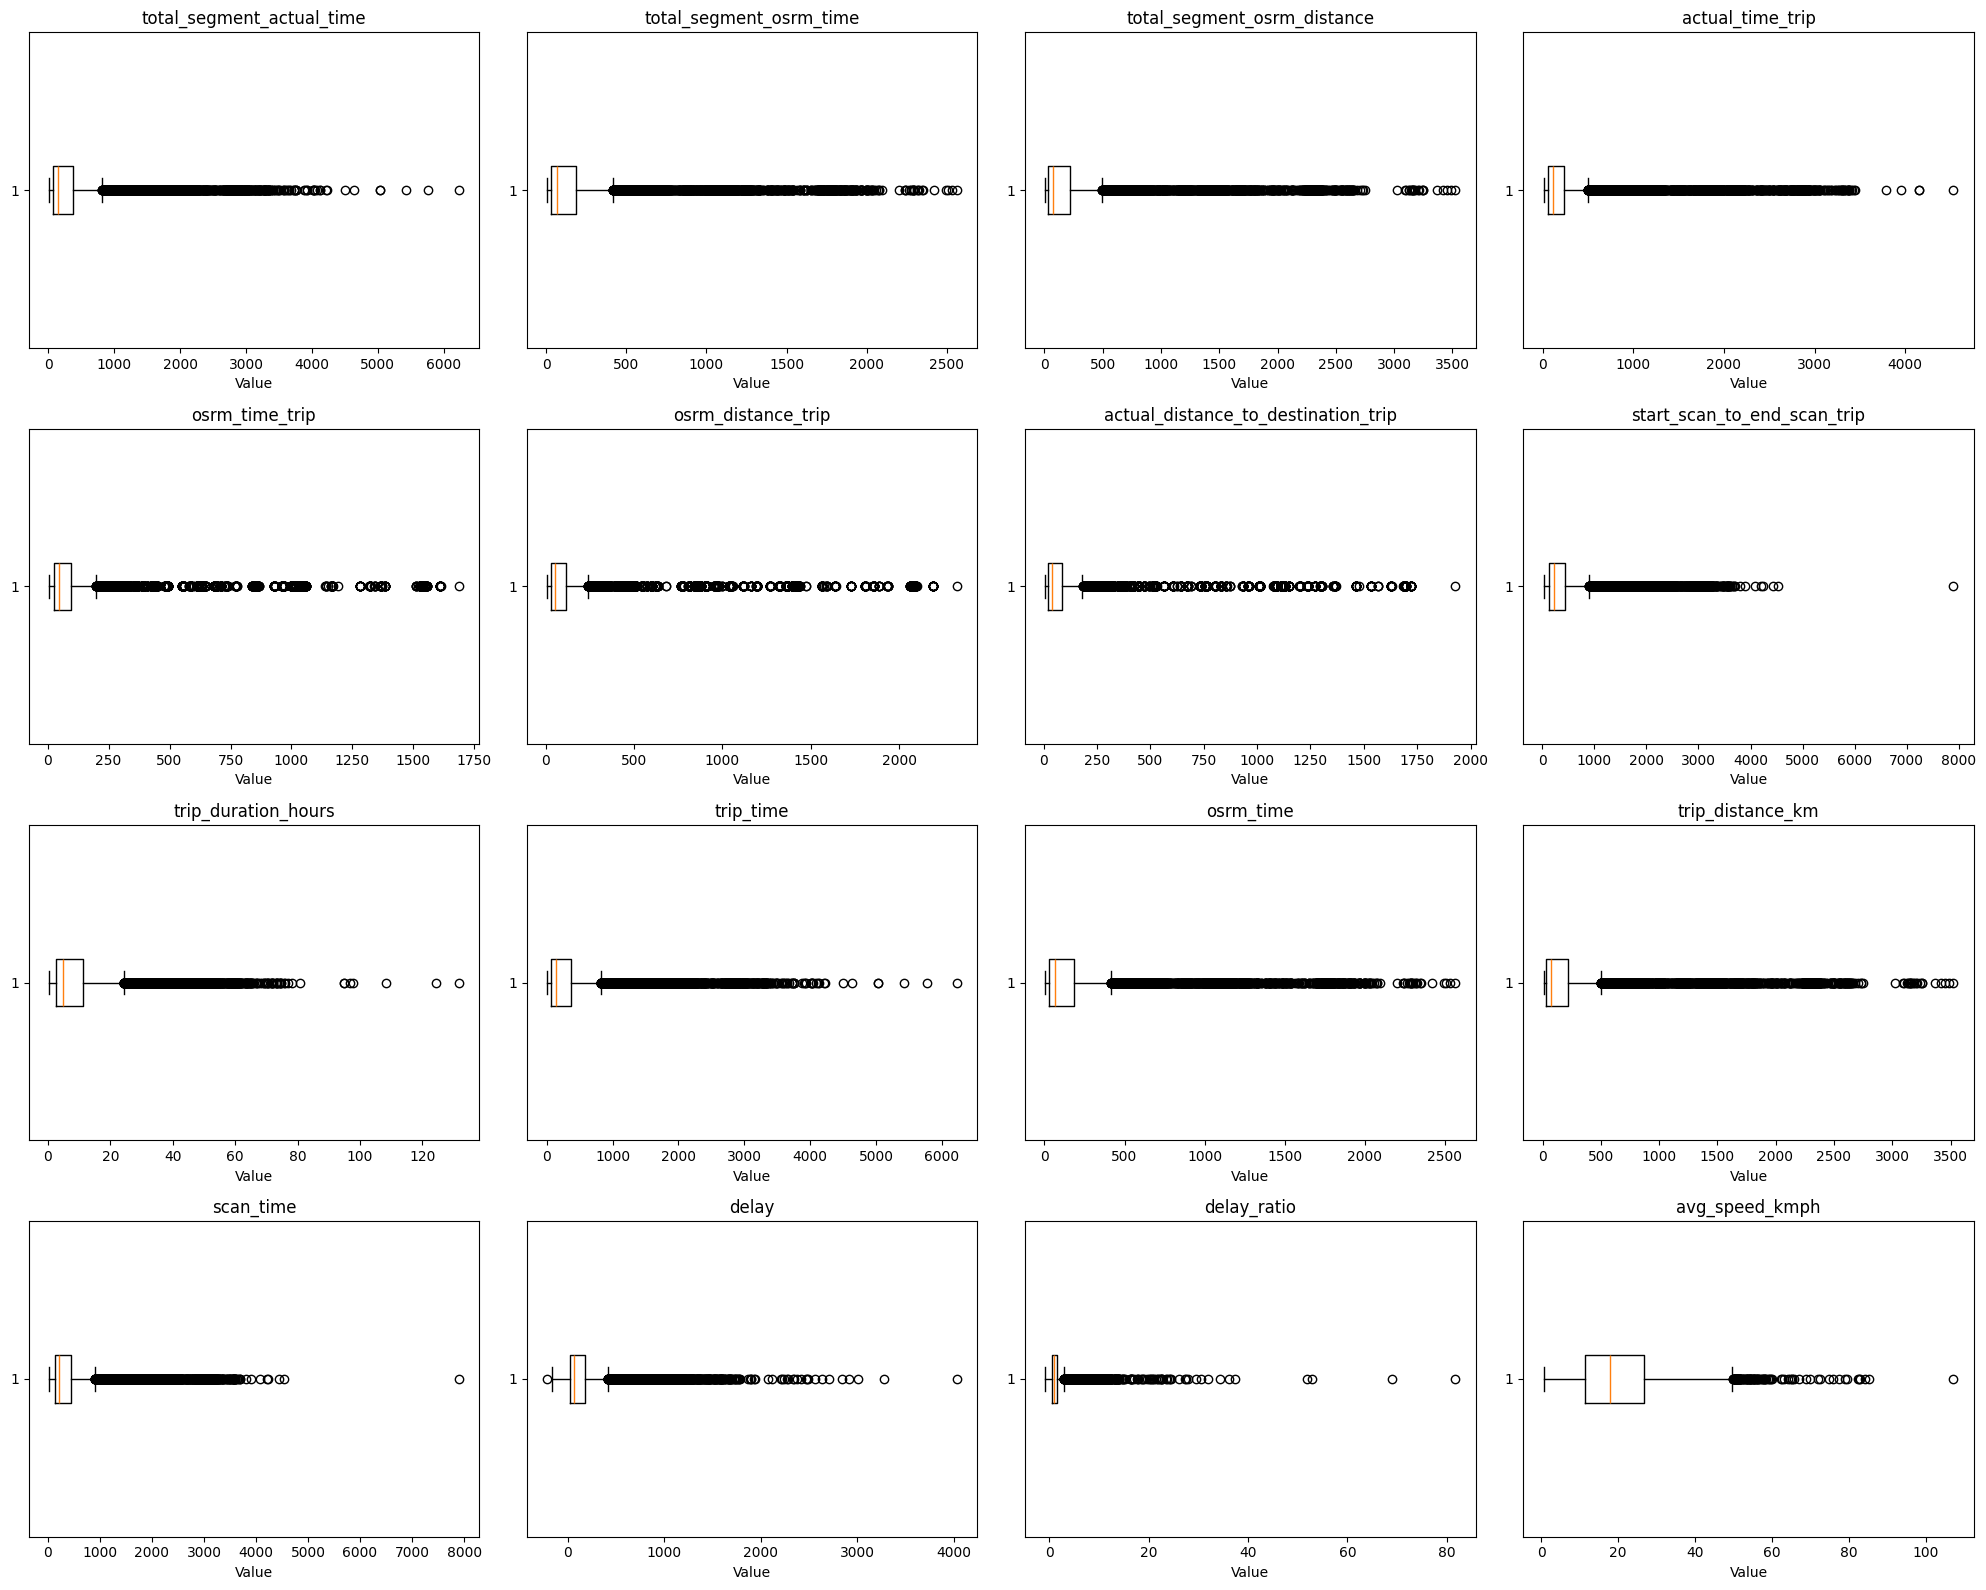

In [ ]:
n = len(numeric_cols)
cols = 4
rows = (n + cols - 1) // cols

fig,axis = plt.subplots(rows,cols,figsize=(20,4*rows))
axis = axis.flatten()

for i,col in enumerate(numeric_cols):
  series = trip_level_df[col].dropna()
  axis[i].boxplot(series.values,vert=False)
  axis[i].set_title(col)
  axis[i].set_xlabel("Value")

plt.tight_layout()
plt.show()

### **3.  Re-check missing values** (after aggregation + feature creation)

In [ ]:
print(trip_level_df.isna().sum())

trip_uuid                              0
total_segment_actual_time              0
total_segment_osrm_time                0
total_segment_osrm_distance            0
total_segment_factor                   0
actual_time_trip                       0
osrm_time_trip                         0
osrm_distance_trip                     0
actual_distance_to_destination_trip    0
start_scan_to_end_scan_trip            0
trip_od_start_min                      0
trip_od_end_max                        0
route_type                             0
data                                   0
trip_start_center                      0
trip_start_destination                 0
trip_end_center                        0
trip_end_destination                   0
trip_time                              0
osrm_time                              0
trip_distance_km                       0
scan_time                              0
trip_duration                          0
trip_duration_hours                    0
trip_duration_mi

## **ONE-HOT ENCODING OF CATEGORICAL VARIABLES**

In [ ]:
# pd.get_dummies() or OHE expects string values
trip_level_df['route_type'] = trip_level_df['route_type'].astype(str)
trip_level_df['data'] = trip_level_df['data'].astype(str)

In [ ]:
# One-hot encoding of 'route_type' and 'data' columns in the trip_level_df:
tmp = trip_level_df[['route_type','data']].fillna('MISSING').astype(str)
# OHE cannot handle NaN values; thus they're converted to str 'MISSING'

In [ ]:
dummies = pd.get_dummies(tmp,prefix = ['route_type','data'],prefix_sep = ' = ',drop_first = False,dtype = 'uint8')
# creates a new DataFrame (dummies) containing binary columns representing each category in route_type and data

In [ ]:
print("Created dummy columns:",list(dummies.columns))

Created dummy columns: ['route_type = Carting', 'route_type = FTL', 'data = test', 'data = training']


* **pd.get_dummies()**: converts categorical variables into dummy/indicator variables for **one-hot encoding**. It creates a new DataFrame where each unique category in the original data becomes a separate binary column (0 or 1) representing the presence of that category in each row.
* **prefix=['route_type','data']**: tells Pandas how to name the new dummy columns
* **prefix_sep='='**: controls how the separator looks
* **drop_first=False**: to keep all dummy columns
* **dtype='uint8'**: ensures that each dummy column uses only 1 byte per value (memory-efficient)

In [ ]:
trip_level_df = pd.concat([trip_level_df.reset_index(drop = True),dummies.reset_index(drop = True)],axis = 1)
# This block attaches the dummy columns to the "trip_level_df" and creates the final encoded dataset

* **trip_level_df.reset_index(drop=True)**: resets the row index to 0,1,2 etc. to ensure that the indices line up perfectly with dummies

## **NORMALIZATION & STANDARDIZATION OF NUMERICAL FEATURES**

### **Application of StandardScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

numeric_cols = trip_level_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

scaled_values = scaler.fit_transform(trip_level_df[numeric_cols])
scaled_df = pd.DataFrame(scaled_values, columns=[c + '_scaled' for c in numeric_cols])

trip_level_df = pd.concat([trip_level_df.reset_index(drop=True),scaled_df.reset_index(drop=True)],axis=1)

In [ ]:
trip_level_df[['trip_time_scaled','osrm_time_scaled','trip_distance_km_scaled','scan_time_scaled','trip_duration_hours_scaled',
               'trip_duration_minutes_scaled','delay_scaled','delay_ratio_scaled','avg_speed_kmph_scaled',
               'avg_speed_kmph_outlier_scaled']].head(2)

,trip_time_scaled,osrm_time_scaled,trip_distance_km_scaled,scan_time_scaled,trip_duration_hours_scaled,trip_duration_minutes_scaled,delay_scaled,delay_ratio_scaled,avg_speed_kmph_scaled,avg_speed_kmph_outlier_scaled
0,-0.335999,-0.295518,-0.289214,-0.551814,-0.526557,-0.526557,-0.343374,-0.251632,1.085411,-0.086484
1,-0.312627,-0.238290,-0.222729,-0.195834,-0.366558,-0.366558,-0.361650,-0.340231,0.564959,-0.086484


## **VISUALIZATIONS & HYPOTHESIS TESTING**

### **Trip duration v/s Scan-to-Scan duration**

In [ ]:
# Ensure od_start_time and od_end_time are datetime
trip_level_df['trip_od_start_min'] = pd.to_datetime(trip_level_df['trip_od_start_min'], errors='coerce')
trip_level_df['trip_od_end_max'] = pd.to_datetime(trip_level_df['trip_od_end_max'], errors='coerce')

# 1) Compute trip_duration (Point A)
trip_level_df['trip_duration'] = (trip_level_df['trip_od_end_max'] - trip_level_df['trip_od_start_min']).dt.total_seconds()

# 2) Extract paired values for comparison
dfp = trip_level_df[['trip_duration', 'start_scan_to_end_scan_trip']].dropna()
a = dfp['trip_duration']
b = dfp['start_scan_to_end_scan_trip']
diff = a - b

# 3) Summary statistics
print("N (paired):", len(dfp))
print("mean(trip_duration) =", a.mean())
print("mean(start_scan_to_end_scan_trip) =", b.mean())
print("mean(diff) =", diff.mean())
print("median(diff) =", diff.median())
print("Cohen's d =", diff.mean() / diff.std(ddof=1))

# paired t-test (parametric)
t_stat, p_t = ttest_rel(a, b)
print("Paired t-test:", t_stat, p_t)

# wilcoxon test (non-parametric)
w_stat, p_w = wilcoxon(a, b)
print("Wilcoxon:", w_stat, p_w)

# Visualization plots:
fig, axes = plt.subplots(1,3, figsize=(15,4))

# 1. Scatterplot
axes[0].scatter(b, a, alpha=0.25)
axes[0].plot([b.min(), b.max()], [b.min(), b.max()], 'k--', linewidth=0.7)
axes[0].set_title('Trip duration vs Scan-based time')
axes[0].set_xlabel('Scan-based time (sec)')
axes[0].set_ylabel('Trip duration (sec)')

# 2. Histogram
axes[1].hist(diff, bins=40)
axes[1].set_title('Diff (trip_duration - scan_time)')
axes[1].set_xlabel('Seconds')

# 3. Boxplot
axes[2].boxplot(diff, vert=False)
axes[2].set_title('Diff boxplot')

plt.tight_layout()
plt.show()

N (paired): 14817
mean(trip_duration) = 32848.60781149437
mean(start_scan_to_end_scan_trip) = 408.17439427684417
mean(diff) = 32440.43341721752
median(diff) = 17074.769878
Cohen's d = 0.8188219929466457


NameError: name 'ttest_rel' is not defined

#### **Hypothesis Testing Conclusion**

There is a very **large and statistically significant difference between the time calculated from the actual OD timestamps (trip_duration) and the scan-based delivery time (start_scan_to_end_scan_trip)**. The mean difference is approximately 9 hours, with a large effect size (Cohen’s d = 0.82). Both the paired t-test and Wilcoxon signed-rank test yield p-values of 0.0, confirming that the distributions are substantially different. This result is expected, as scan-based time only captures the scanning window and not the entire physical transit duration.

### **Actual Time-Aggregated Value v/s OSRM Time-Aggregated Value**

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

a_col = 'actual_time_trip'
b_col = 'osrm_time_trip'

# Remove missing pairs
dfp = trip_level_df[['actual_time_trip', 'osrm_time_trip']].dropna()
a = dfp['actual_time_trip']
b = dfp['osrm_time_trip']
diff = a - b

print("mean(a) =", a.mean(), "mean(b) =", b.mean())
print("mean(diff) =", diff.mean(), "median(diff) =", diff.median())
cohen_d = diff.mean() / diff.std(ddof=1) if diff.std(ddof=1) != 0 else np.nan
print("Cohen's d (paired):", cohen_d)

# paired t-test (parametric)
t_stat, p_t = ttest_rel(a, b)
print("Paired t-test: t =", t_stat, "p =", p_t)

# wilcoxon test (non-parametric)
w_stat, p_w = wilcoxon(a, b)
print("Wilcoxon:", w_stat, p_w)

# Visualization plots:
fig, axes = plt.subplots(1,3, figsize=(15,4))

# 1. Scatterplot
axes[0].scatter(b, a, alpha=0.25)
axes[0].plot([b.min(), b.max()], [b.min(), b.max()], 'k--', linewidth=0.7)
axes[0].set_xlabel('OSRM time (in seconds)')
axes[0].set_ylabel('Actual time (in seconds)')
axes[0].set_title('Actual vs OSRM (trip-level)')

# 2. Diff histplot
axes[1].hist(diff, bins=40)
axes[1].set_title('Distribution of (actual - osrm)')
axes[1].set_xlabel('Seconds')

# 3. Diff boxplot
axes[2].boxplot(diff.values, vert=False)
axes[2].set_title('Diff boxplot (actual - osrm)')
plt.tight_layout()
plt.show()

#### **Hypothesis Testing Conclusion**

There is a **statistically significant difference between the actual cumulative time recorded by the system and the OSRM-predicted time**. On average, actual times are approximately 2.6 minutes longer than OSRM predictions, with a median difference of 61 seconds and a medium effect size (Cohen’s d ≈ 0.58). Both paired t-tests and Wilcoxon signed-rank tests yield p-values of 0.0, confirming that **actual trip timings tend to exceed OSRM ideal routing estimates**. This suggests that operational realities (traffic, loading delays, local constraints) consistently make trips slower than their OSRM-estimated benchmarks.

### **Actual Time-Aggregated Value v/s Segment Actual Time-Aggregated Value**

In [ ]:
# Extract paired values
dfp = trip_level_df[['actual_time_trip', 'total_segment_actual_time']].dropna()
a = dfp['actual_time_trip']
b = dfp['total_segment_actual_time']
diff = a - b

# Summary statistics
print("N (paired):", len(dfp))
print("mean(actual) =", a.mean())
print("mean(segment_sum) =", b.mean())
print("mean(diff) =", diff.mean())
print("median(diff) =", diff.median())
print("Cohen's d =", diff.mean() / diff.std(ddof=1))

# paired t-test (parametric)
t_stat, p_t = ttest_rel(a, b)
print("Paired t-test:", t_stat, p_t)

# wilcoxon test (non-parametric)
w_stat, p_w = wilcoxon(a, b)
print("Wilcoxon:", w_stat, p_w)

# Visualization plots:
fig, axes = plt.subplots(1,3, figsize=(15,4))

# 1. Scatterplot
axes[0].scatter(b, a, alpha=0.25)
axes[0].plot([b.min(), b.max()], [b.min(), b.max()], 'k--', linewidth=0.7)
axes[0].set_title('Actual vs Segment-sum')
axes[0].set_xlabel('Segment-sum actual time')
axes[0].set_ylabel('Actual time')

# 2. Diff histogram
axes[1].hist(diff, bins=40)
axes[1].set_title('Diff (actual - segment_sum)')
axes[1].set_xlabel('Seconds')

# 3. Diff boxplot
axes[2].boxplot(diff, vert=False)
axes[2].set_title('Diff boxplot')

plt.tight_layout()
plt.show()

#### **Hypothesis Testing Conclusion**

The comparison shows that **segment-aggregated actual time** (≈354 sec) **is generally higher than the trip-level actual time** (≈278 sec), leading to a negative mean difference of −75.8 seconds, though the median difference is 0, indicating that for many trips the values match exactly. The moderate effect size (Cohen’s d ≈ −0.46) and the highly significant results from both the paired t-test and Wilcoxon test (p = 0.0) confirm that these two measures differ systematically. Overall, **segment-level logs tend to slightly overstate total actual time compared to the trip-level aggregated value**, likely due to additional micro-delays or transitions captured at the segment level but not reflected in the consolidated trip metric.

### **OSRM Distance-Aggregated Value v/s Segment OSRM Distance-Aggregated Value**

In [ ]:
# Extract paired values
dfp = trip_level_df[['osrm_distance_trip', 'total_segment_osrm_distance']].dropna()
a = dfp['osrm_distance_trip']
b = dfp['total_segment_osrm_distance']
diff = a - b

# Summary statistics
print("N (paired):", len(dfp))
print("mean(osrm_distance_trip) =", a.mean())
print("mean(total_segment_osrm_distance) =", b.mean())
print("mean(diff) =", diff.mean())
print("median(diff) =", diff.median())
print("Cohen's d =", diff.mean() / diff.std(ddof=1))

# paired t-test (parametric)
t_stat, p_t = ttest_rel(a, b)
print("Paired t-test:", t_stat, p_t)

# wilcoxon test (non-parametric)
w_stat, p_w = wilcoxon(a, b)
print("Wilcoxon:", w_stat, p_w)

# Visualization plots:
fig, axes = plt.subplots(1,3, figsize=(15,4))

# 1. Scatterplot
axes[0].scatter(b, a, alpha=0.25)
axes[0].plot([b.min(), b.max()], [b.min(), b.max()], 'k--', linewidth=0.7)
axes[0].set_title('OSRM distance (trip) vs sum(segment_osrm_distance)')
axes[0].set_xlabel('Segment-sum OSRM distance (km)')
axes[0].set_ylabel('Trip-level OSRM distance (km)')

# 2. Diff histogram
axes[1].hist(diff, bins=40)
axes[1].set_title('Diff (trip - segment_sum)')
axes[1].set_xlabel('Distance (km)')

# 3. Diff boxplot
axes[2].boxplot(diff, vert=False)
axes[2].set_title('Diff boxplot')

plt.tight_layout()
plt.show()

#### **Hypothesis Testing Conclusion**

**Segment-aggregated OSRM distance** (≈223.20 km) **is consistently higher than the trip-level OSRM distance** (≈155.88 km), producing a negative mean difference of −67.32 km and a median difference of −12.72 km, indicating that segments generally sum to a longer total distance than the single trip-level OSRM estimate. The moderate effect size (Cohen’s d ≈ −0.48), along with highly significant results from both the paired t-test and Wilcoxon test (p = 0.0), confirms that this difference is systematic rather than random. This suggests that **route segmentation introduces additional minor path lengths**—likely due to intermediate nodes or micro-routing adjustments—causing cumulative segment distances to exceed the direct trip-level OSRM calculation.


### **OSRM Time-Aggregated Value v/s Segment OSRM Time-Aggregated Value**

In [ ]:
# Extract paired values
dfp = trip_level_df[['osrm_time_trip', 'total_segment_osrm_time']].dropna()
a = dfp['osrm_time_trip']
b = dfp['total_segment_osrm_time']
diff = a - b

# Summary statistics
print("N (paired):", len(dfp))
print("mean(osrm_time_trip) =", a.mean())
print("mean(total_segment_osrm_time) =", b.mean())
print("mean(diff) =", diff.mean())
print("median(diff) =", diff.median())
print("Cohen's d =", diff.mean() / diff.std(ddof=1))

# paired t-test (parametric)
t_stat, p_t = ttest_rel(a, b)
print("Paired t-test:", t_stat, p_t)

# wilcoxon test (non-parametric)
w_stat, p_w = wilcoxon(a, b)
print("Wilcoxon:", w_stat, p_w)

# Visualization plots:
fig, axes = plt.subplots(1,3, figsize=(15,4))

# 1. Scatterplot
axes[0].scatter(b, a, alpha=0.25)
axes[0].plot([b.min(), b.max()], [b.min(), b.max()], 'k--', linewidth=0.7)
axes[0].set_title('OSRM time (trip) vs sum(segment_osrm_time)')
axes[0].set_xlabel('Segment-sum OSRM time (sec)')
axes[0].set_ylabel('Trip-level OSRM time (sec)')

# 2. Diff histogram
axes[1].hist(diff, bins=40)
axes[1].set_title('Diff (trip - segment_sum)')
axes[1].set_xlabel('Seconds')

# 3. Diff boxplot
axes[2].boxplot(diff, vert=False)
axes[2].set_title('Diff boxplot')

plt.tight_layout()
plt.show()

#### **Hypothesis Testing Conclusion**

**Segment-aggregated OSRM time** (≈180.95 sec) **is consistently higher than the trip-level OSRM time** (≈121.83 sec), yielding a negative mean difference of −59.12 seconds and a median difference of −14 seconds. The moderate effect size (Cohen’s d ≈ −0.52) and the highly significant paired t-test and Wilcoxon results (p = 0.0) show that this discrepancy is systematic. This indicates that **summing OSRM times over multiple segments inflates total predicted time compared with the single, direct OSRM estimate for the trip** likely because segmenting introduces additional intermediate routing elements or micro-delays that are not present in the consolidated trip-level OSRM calculation.

### **Correlation heatmap**

In [ ]:
core_num_cols = [c for c in trip_level_df.columns
                 if trip_level_df[c].dtype in ('float64','int64')
                 and not c.endswith('_scaled')
                 and not c.endswith('_outlier')]

corr = trip_level_df[core_num_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(corr,mask=mask,cmap='coolwarm',linewidths=0.5,linecolor='white')
plt.title("Correlation Heatmap")
plt.show()

### **Scatterplot of Distance vs Time**

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(trip_level_df['trip_distance_km'], trip_level_df['trip_time'], alpha=0.25)
plt.xlabel("Distance (in kms)")
plt.ylabel("Time (in seconds)")
plt.title("Distance vs Time")
plt.show()

### **Histogram of Delay**

In [ ]:
sns.histplot(trip_level_df['delay'], bins=30, kde=True)
plt.title("Distribution of Delay")
plt.xlabel("Delay (sec)")
plt.ylabel("Frequency")
plt.show()

### **Boxplot of Delay by Route Type**

In [ ]:
plt.figure(figsize=(15,7))
sns.boxplot(data=trip_level_df,x='delay', y='route_type')
plt.title("Delay by Route Type")
plt.suptitle("")
plt.show()

---

## **BUSINESS INSIGHTS**

1.  **Actual delivery times are consistently higher than OSRM-predicted times**. Across almost all trips, actual delivery time exceeds the routing engine’s prediction. This shows real-world delays (traffic, loading/unloading, waiting time, operational bottlenecks) not captured by OSRM.

2. Segment-level totals inflate distance and time compared to trip-level values. **Summed segment distances and times exceed direct trip estimates**, indicating inefficiencies from multi-stop or multi-hop trips.

3. Major delays occur early in the trip (od_start_time → od_end_time). **Trip duration far exceeds “scan-to-scan” delivery time**, showing **pre-dispatch activities (sorting, loading, queueing) consume significant time**.

4. FTL vs Carting: Route type influences speed and time. **FTL routes finish earlier** with fewer deviations, while Carting routes—small vehicles covering smaller zones—show more delays and variability.

5. Some source–destination corridors are consistently slower. Certain routes show larger differences between actual vs predicted time, indicating **corridor-specific inefficiencies** like traffic-heavy zones, warehouse delays, or suboptimal routing.

6. **Scan-to-scan times** are very small compared to overall trip time. This shows that the physical journey between hubs is fast; **most delays occur in handover, processing, and queueing before or after movement**.

7. Trips with **higher OSRM distance also tend to have higher actual time**. There is a positive relationship, indicating that long-distance corridors consistently take longer than predicted by OSRM, implying predictable and scalable delays.

8. Strong **correlation patterns show overlapping features**. Actual time, segment-aggregated time, and OSRM time are highly correlated, indicating operational metrics are consistent but inflated by real-world constraints.

9. High variance (or **outliers**) exist in segment times. Some segments take exceptionally long, **indicating operational issues** at specific hubs or routes

10. Source and destination centers with high frequency represent major operational corridors. **A small set of hubs contributes to a large share of movement, highlighting the main backbone of Delhivery’s network**.

## **CONCLUSION COMPARING ACTUAL V/S OSRM PERFORMANCE**

Actual delivery performance is **consistently slower than OSRM predictions** for both time and distance, with **significant and systematic delays** observed across nearly all trips. **Segment-level totals further amplify these gaps**, indicating that real-world operations introduce **additional inefficiencies not captured by OSRM**. Overall, **OSRM underestimates travel time and distance**, while **actual delivery runs show higher variability and operational overhead**.

## **RECOMMENDATIONS**

1.  **Prioritize improving high-delay corridors** : Identify the top 10 routes where actual time is far above predicted time, and focus optimization efforts (staffing, scheduling, lane changes, or priority handling).

2.  **Improve pre-dispatch processes** : Since most delays occur before the trip actually begins, streamline sorting, loading, and handover processes in busy hubs.

3.  **Re-evaluate segmentation strategy** : Too many segments are contributing to inefficiency. Reducing unnecessary intermediate stops or re-routing can cut overall time.

4.  **Adjust planning buffers for high-variability routes** : Delay patterns are predictable; add realistic buffers for corridors with consistent overruns to improve ETA accuracy.

5.  **Optimize carting routes** : Carting (small vehicle) trips show more variability — redesigning route layouts or adjusting fleet allocation could improve reliability.

6.  **Use FTL routes wherever feasible** : Since FTL trips consistently perform better, shifting eligible shipments to FTL routing can improve delivery speed.

7.  **Fix hub-level bottlenecks** : Outliers in segment times point to specific hubs causing repeated delays — conduct operational audits there.

8.  **Enhance OSRM prediction tuning** : Since OSRM underestimates time, incorporate real-world historical delay factors to improve ETA predictions.

9.  **Reduce unnecessary scans and micro-stops** : Scan-to-scan time is minimal, but too many scan events inflate operational workload; reducing them can increase efficiency.

10. **Focus resources on high-volume hubs** : Since a small group of centers handles most of the traffic, improving these hubs will have the highest impact on delivery performance.



.

---
---
---

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.